In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
pd.set_option('display.max_columns', None)
import tensorflow as tf
import xml.etree.ElementTree as ET

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score,ndcg_score,mean_squared_error

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dropout, Embedding,BatchNormalization,Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [4]:
#!pip install tensorflow_recommenders 
#import tensorflow_recommenders as tfrs

In [5]:
data_path = 'metadata/'

In [6]:
interaction_df = pd.read_csv(data_path +'interactions.csv').drop('Unnamed: 0',axis=1)

In [7]:
interaction_df.head(5)

,PERSON_ID,ProviderCode,SurveyAnswerScore,RecommendStar,ratings,age,survey_score,star_rating,zip_code,FACILITYCODE,SpecialtyCode,SpecialtyDescription,GENDER_Female,GENDER_Male
0,00123db9a36e9f9277d6ce32c3fdd1e49809845399741b...,XF6BG,2.500000,5.000000,3.75,39.0,3.05,3.67,34950,81DB7D,PS305,Family Medicine,1,0
1,32e8750a2e31a34c71d700df32a773adcab8db3109117b...,XF6BG,4.708333,5.000000,4.85,39.0,3.05,3.67,34950,81DB7D,PS305,Family Medicine,0,1
2,4a2bfb67462d6f2d7b70752411114edc1325c8d9efb885...,XF6BG,4.400000,5.000000,4.70,39.0,3.05,3.67,34950,81DB7D,PS305,Family Medicine,1,0
3,c5a78302c3051b68f31cf426eff4f1b90b324d44ecdbb2...,XF6BG,2.947368,3.105263,3.03,39.0,3.05,3.67,34950,81DB7D,PS305,Family Medicine,0,1
4,df0ce9bc392f26eb5fc52244d195b5f6ab9ce6d14ddaf5...,XF6BG,2.272727,2.000000,2.14,39.0,3.05,3.67,34950,81DB7D,PS305,Family Medicine,1,0


In [8]:
#num interactions = 8519 , num PERSON_ID = 3220  , num_PROVIDER = 580
num_persons = len(interaction_df['PERSON_ID'].unique()) ; num_providers = len(interaction_df['ProviderCode'].unique())
num_persons , num_providers

(3220, 580)

## DCN Experiment starts here ##

#### Model Featurization

In [9]:
user_features = ['PERSON_ID', 'age', 'GENDER_Female', 'GENDER_Male']
provider_features = ['ProviderCode', 'survey_score', 'star_rating']
target = 'ratings'

# Split the unique user IDs into training and testing sets (80:20 split)
unique_user_ids = interaction_df['PERSON_ID'].unique()
train_user_ids, test_user_ids = train_test_split(unique_user_ids, test_size=0.2, random_state=42)

# Create boolean masks for filtering
train_mask = interaction_df['PERSON_ID'].isin(train_user_ids)
test_mask = interaction_df['PERSON_ID'].isin(test_user_ids)

# Filter interaction data for training and testing sets
train_interactions = interaction_df[train_mask]
test_interactions = interaction_df[test_mask]

# Standardize the continuous features
scaler = StandardScaler()
train_interactions[['age', 'survey_score', 'star_rating']] = scaler.fit_transform(train_interactions[['age', 'survey_score', 'star_rating']])
test_interactions[['age', 'survey_score', 'star_rating']] = scaler.transform(test_interactions[['age', 'survey_score', 'star_rating']])

# Map user and provider IDs to numerical indices for embedding
user_id_map = {id: idx for idx, id in enumerate(interaction_df['PERSON_ID'].unique())}
provider_id_map = {id: idx for idx, id in enumerate(interaction_df['ProviderCode'].unique())}

train_interactions['user_id_idx'] = train_interactions['PERSON_ID'].map(user_id_map)
train_interactions['provider_id_idx'] = train_interactions['ProviderCode'].map(provider_id_map)

test_interactions['user_id_idx'] = test_interactions['PERSON_ID'].map(user_id_map)
test_interactions['provider_id_idx'] = test_interactions['ProviderCode'].map(provider_id_map)

# Prepare inputs for the model
X_train_user = train_interactions[['user_id_idx', 'age', 'GENDER_Female', 'GENDER_Male']].values
X_train_provider = train_interactions[['provider_id_idx', 'survey_score', 'star_rating']].values

X_test_user = test_interactions[['user_id_idx', 'age', 'GENDER_Female', 'GENDER_Male']].values
X_test_provider = test_interactions[['provider_id_idx', 'survey_score', 'star_rating']].values

y_train = train_interactions[target].values
y_test = test_interactions[target].values

C:\Users\samra\AppData\Local\Temp\ipykernel_11412\312981952.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_interactions[['age', 'survey_score', 'star_rating']] = scaler.fit_transform(train_interactions[['age', 'survey_score', 'star_rating']])
C:\Users\samra\AppData\Local\Temp\ipykernel_11412\312981952.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_interactions[['age', 'survey_score', 'star_rating']] = scaler.transform(test_interactions[['age', 'survey_score', 'star_rating']])
C:\Users

In [14]:
test_user_ids

array(['024504d4cf3fab02afa7a1be2cb56a41070d25aaf118bfb9566f22f0479d269f',
       '5adca65b050115deca23407b3ecc16ce99d22d1249973c40ba5f4ee2ddc9f5ea',
       '40ec342d1fe12f35cf5e123281d6c5709d0024133523887a83939c892261eb92',
       'ac10cc7d784ddba0797d84c4b9f8927bf12ca806d7e363407e3f073c0df4fca8',
       'dd419c44fd5ef8ddfc27de9aa8c7e22c5e213ad32fb861b34fbf01fe667f70ff',
       '1d3c578e5a9c2f209b96d98c1ddd6b3b668839f635881dcae8fc09d584503389',
       '308b23a4a566135e8e19aa7842446eb45de3f8e642bdd3e8bb9320e556f22527',
       'fb565be9491a1143e6c6247bba2cd2ff09c14fa35022d4cc5facc12575535116',
       'd5293244acbd2006cf04d2f7880ae3209179f0939152b04a0e2884541ebd4324',
       'a5ce022f98552a82608bda3a281c7831042197303be69dc6dbf73de6f952faae',
       '5c642c492d1ba2e8f10b3964b2821cd287cecd7c725bc06e957778ef2221727c',
       'd8afb6459cdecce17a8960419f08b6513175a1967b7b48c074d30eed636b7db7',
       'b821edd4ead96f6cfe0c8e168cc202fa17c876b4b9670617ab510b2b66646031',
       'c7da61785f0c89d51

#### DCN Training  ####

In [10]:
def create_embedding_layer(input_dim, output_dim, input_length=1):
    input_layer = Input(shape=(input_length,))
    embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim)(input_layer)
    return input_layer, Flatten()(embedding_layer)

def create_dcn_model(num_users, num_providers, embedding_dim_user=16, embedding_dim_provider=16):
    # User embeddings
    user_input, user_embedding = create_embedding_layer(num_users, embedding_dim_user)
    user_age_input = Input(shape=(1,), name='user_age')
    user_gender_input = Input(shape=(2,), name='user_gender')  # Gender as two columns (one-hot encoding)

    user_concatenated = Concatenate()([user_embedding, user_age_input, user_gender_input])
    user_embedding_final = Dense(embedding_dim_user, activation='relu')(user_concatenated)

    # Provider embeddings
    provider_input, provider_embedding = create_embedding_layer(num_providers, embedding_dim_provider)
    provider_survey_score_input = Input(shape=(1,), name='provider_survey_score')
    provider_star_rating_input = Input(shape=(1,), name='provider_star_rating')

    provider_concatenated = Concatenate()([provider_embedding, provider_survey_score_input, provider_star_rating_input])
    provider_embedding_final = Dense(embedding_dim_provider, activation='relu')(provider_concatenated)

    # Combine user and provider embeddings
    concatenated = Concatenate()([user_embedding_final, provider_embedding_final])

    # Cross Network
    cross_layer = concatenated
    for _ in range(3):  # 3 cross layers
        units = concatenated.shape[-1]
        cross_layer = tf.keras.layers.Dense(units, activation='relu')(cross_layer)

    # Deep Network
    deep_layer = Dense(128, activation='relu')(concatenated)
    deep_layer = Dropout(0.5)(deep_layer)
    deep_layer = BatchNormalization()(deep_layer)
    deep_layer = Dense(64, activation='relu')(deep_layer)
    deep_layer = Dropout(0.5)(deep_layer)
    deep_layer = BatchNormalization()(deep_layer)

    # Combine Cross Network and Deep Network
    combined = Concatenate()([cross_layer, deep_layer])
    output = Dense(1, activation='linear')(combined)

    model = Model(inputs=[user_input, user_age_input, user_gender_input, provider_input, provider_survey_score_input, provider_star_rating_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

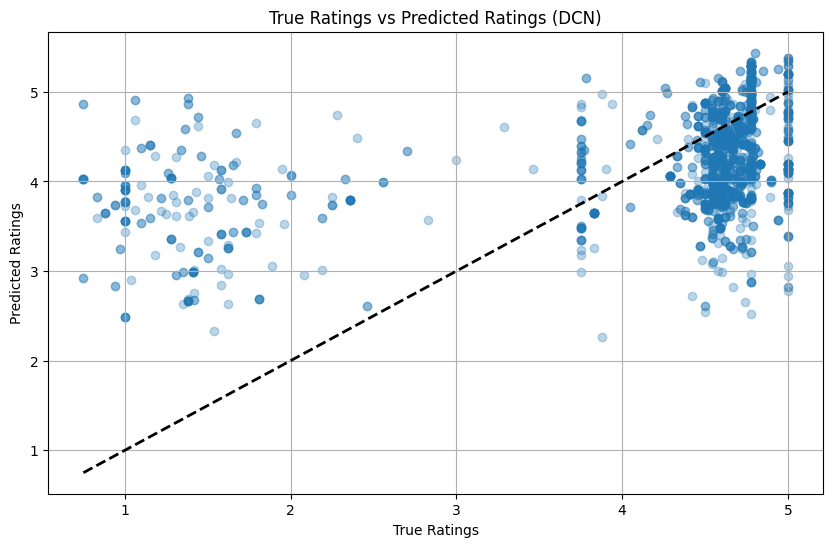

DCN NDCG Score: 0.9912572004586455


In [11]:
# Prepare inputs for the model
num_users = interaction_df['PERSON_ID'].nunique()  # Total number of unique users in the entire dataset
num_providers = interaction_df['ProviderCode'].nunique()  # Total number of unique providers in the entire dataset


# Create and train the DCN model
dcn_strategy = tf.distribute.MirroredStrategy()  # Enable GPU strategy for distributed training
with dcn_strategy.scope():
    dcn_model = create_dcn_model(num_users, num_providers, embedding_dim_user=16, embedding_dim_provider=16)
    

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/best_dcn.h5', save_best_only=True, monitor='val_loss')
tensorboard = TensorBoard(log_dir='./logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)
callbacks = [early_stopping, checkpoint, tensorboard, reduce_lr]

# Train the model
history = dcn_model.fit(
    [X_train_user[:, 0], X_train_user[:, 1].reshape(-1, 1), X_train_user[:, 2:], 
     X_train_provider[:, 0], X_train_provider[:, 1].reshape(-1, 1), X_train_provider[:, 2].reshape(-1, 1)],
    y_train, 
    epochs=100, 
    validation_data=(
        [X_test_user[:, 0], X_test_user[:, 1].reshape(-1, 1), X_test_user[:, 2:], 
         X_test_provider[:, 0], X_test_provider[:, 1].reshape(-1, 1), X_test_provider[:, 2].reshape(-1, 1)], 
        y_test
    ), 
    batch_size=16, 
    callbacks=callbacks
)


# Save the model
dcn_model.save('models/dcn_reco_model.h5')

# Display training summary
print("DCN Model training completed.")

# Predictions and evaluation
y_pred_dcn = dcn_model.predict([X_test_user[:, 0], X_test_user[:, 1].reshape(-1, 1), X_test_user[:, 2:], 
                                X_test_provider[:, 0], X_test_provider[:, 1].reshape(-1, 1), X_test_provider[:, 2].reshape(-1, 1)])
rmse_dcn = np.sqrt(mean_squared_error(y_test, y_pred_dcn))
print("DCN RMSE: %f" % (rmse_dcn))

# Create a scatter plot to compare y_test and y_pred_dcn
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_dcn, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True Ratings vs Predicted Ratings (DCN)')
plt.grid(True)
plt.show()

y_test_reshaped = y_test.reshape(1, -1)
y_pred_reshaped = y_pred_dcn.reshape(1, -1)

# Calculate NDCG score for DCN
ndcg_dcn = ndcg_score(y_test_reshaped, y_pred_reshaped)
print(f"DCN NDCG Score: {ndcg_dcn}")